### Funciones para todos los ejercicios

In [147]:
import random
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
plt.style.use('dark_background')


# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = 0
X_MAX = 31
OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2


#  -----------------------------------------------------------------
# funcion para mapear el valor binario a un rango [X_MIN, X_MAX]
#  -----------------------------------------------------------------
def binario_a_decimal(cromosoma):
    decimal = int(cromosoma, 2)
    x = X_MIN + decimal * (X_MAX - X_MIN) / ((2 ** LONGITUD_CROMOSOMA) - 1)
    return x

#  -----------------------------------------------------------------
# Aqui en las proximas lineas se puede ver que mi funcion objetivo es
# a veces diferente de mi funcion fitness, depende del problema a resolver
#  -----------------------------------------------------------------


#  -----------------------------------------------------------------
# funcion objetivo x^2
#  -----------------------------------------------------------------
def funcion_objetivo(x):
    return x ** 2


#  -----------------------------------------------------------------
# funcion fitness o tambien llamada funcion de aptitud (1/(x^2 + epsilon))
#  -----------------------------------------------------------------
def aptitud(cromosoma):
    x = binario_a_decimal(cromosoma)
    if OBJ == 'MIN':
        return 1 / (funcion_objetivo(x) + EPSILON)
    elif OBJ =='MAX':
        return x ** 2


#  -----------------------------------------------------------------
# se inicializa la poblacion
#  -----------------------------------------------------------------
def inicializar_poblacion(tamanio_poblacion, longitud_cromosoma):
    poblacion = []
    for tp in range(tamanio_poblacion):
        cromosoma = ''
        for lc in range(longitud_cromosoma):
            cromosoma = cromosoma+str(random.randint(0, 1))
        poblacion.append(cromosoma)
    return poblacion

#  -----------------------------------------------------------------
# seleccion por ruleta
#  -----------------------------------------------------------------
def seleccion_ruleta(poblacion, aptitud_total):
    probabilidades = []
    for individuo in poblacion:
        prob = aptitud(individuo) / aptitud_total
        probabilidades.append(prob)

    probabilidades_acumuladas = []
    suma = 0
    for prob in probabilidades:
        suma += prob
        probabilidades_acumuladas.append(suma)

    r = random.random()
    for i, acumulada in enumerate(probabilidades_acumuladas):
        if r <= acumulada:
            return poblacion[i]


#  -----------------------------------------------------------------
# seleccion por torneo
#  -----------------------------------------------------------------
def seleccion_torneo(poblacion, tamanio_torneo=TAMANIO_TORNEO):
    progenitores = []
    for _ in range(len(poblacion)):
        candidatos = random.sample(poblacion, tamanio_torneo)
        progenitor = max(candidatos, key=aptitud)  # se selecciona el mejor individuo del torneo
        progenitores.append(progenitor)
    return progenitores


# -----------------------------------------------------------------
# seleccion por ranking lineal
# -----------------------------------------------------------------
def seleccion_ranking(poblacion):
    # se calcula la aptitud de cada individuo
    aptitudes = []
    for individuo in poblacion:
        aptitudes.append(aptitud(individuo))

    # se ordena la poblacion por aptitud (mayor aptitud es mejor)
    # x es la tupla de zip, de la cual se toma el segundo elemento (x[1]) para
    # ser ordenada la tupla por ese elemento, en este caso por aptitud
    poblacion_ordenada = sorted(zip(poblacion, aptitudes), key=lambda x: x[1])

    # se calcula probabilidades segun el ranking lineal
    N = len(poblacion)
    s = 1.7  # Factor de seleccion comunmente usado
    probabilidades = []
    for i in range(N):
        prob = (2 - s) / N + (2 * i * (s - 1)) / (N * (N - 1))
        probabilidades.append(prob)

    # se selecciona un progenitor basado en las probabilidades
    r = random.random()
    suma = 0
    for i in range(N):
        suma = suma + probabilidades[i]
        if r <= suma:
            return poblacion_ordenada[i][0]  # se retornar el cromosomas

#  -----------------------------------------------------------------
# cruce monopunto con probabilidad de cruza pc = TASA_CRUCE
#  -----------------------------------------------------------------
def cruce_mono_punto(progenitor1, progenitor2, tasa_cruce):
    if random.random() < tasa_cruce:
        punto_cruce = random.randint(1, len(progenitor1) - 1)
        descendiente1 = progenitor1[:punto_cruce] + progenitor2[punto_cruce:]
        descendiente2 = progenitor2[:punto_cruce] + progenitor1[punto_cruce:]
    else:
        descendiente1, descendiente2 = progenitor1, progenitor2
    return descendiente1, descendiente2


#  -----------------------------------------------------------------
# mutacion
#  -----------------------------------------------------------------
def mutacion(cromosoma, tasa_mutacion):
    cromosoma_mutado = ""
    for bit in cromosoma:
        if random.random() < tasa_mutacion:
            cromosoma_mutado = cromosoma_mutado + str(int(not int(bit)))
        else:
            cromosoma_mutado = cromosoma_mutado + bit
    return cromosoma_mutado


#  -----------------------------------------------------------------
# aplicación de operadores geneticos
#  -----------------------------------------------------------------
def algoritmo_genetico(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones, seleccion, elitismo):
    poblacion = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    mejor_funcion_objetivo_generaciones = []  # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):
        print("Generación:", generacion + 1)

        # se calcula aptitud total para luego
        aptitud_total = sum(aptitud(cromosoma) for cromosoma in poblacion)

        print("Aptitud total:", aptitud_total)

        #  -----------------------------------------------------------------
        
        if seleccion == 'ruleta':
            # seleccion de progenitores con el metodo ruleta
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ruleta(poblacion, aptitud_total))
        
        elif seleccion == 'torneo':            
            # seleccion de progenitores con el metodo de torneo
            progenitores = seleccion_torneo(poblacion)
        
        elif seleccion == 'ranking':            
            # seleccion de progenitores con el metodo de ranking lineal
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ranking(poblacion))
        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, tamanio_poblacion, 2):
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])

        #  -----------------------------------------------------------------
        # Mutacion
        descendientes_mutados = []
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

        if elitismo:
            # Aquí se aplica elitismo
            # Se reemplazan los peores cromosomas con los mejores progenitores
            poblacion.sort(key=aptitud)  # se ordena la poblacion por aptitud en forma ascendente
            # se ordena los descendientes por aptitud en forma descendente
            descendientes_mutados.sort(key=aptitud, reverse=True)
            for i in range(len(descendientes_mutados)):
                if aptitud(descendientes_mutados[i]) > aptitud(poblacion[i]):
                    poblacion[i] = descendientes_mutados[i]                

        else: # si no hay elitismo, todos los descendientes pasan a ser la nueva poblacion
            poblacion = descendientes_mutados

        # Mostrar el mejor individuo de la generacion
        mejor_individuo = max(poblacion, key=aptitud)  # Buscar el maximo para la aptitud
        mejor_funcion_objetivo_generaciones.append(funcion_objetivo(binario_a_decimal(mejor_individuo)))

        print("mi", mejor_individuo)
        print("Mejor individuo:", binario_a_decimal(mejor_individuo), "Aptitud:", aptitud(mejor_individuo))
        print("_________________________________________________________________________________")

    # Graficar la evolución de la aptitud
    plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la Función Objetivo')
    plt.title('Curva de Convergencia del Algoritmo Genético')
    plt.grid(True)
    plt.show()
    return max(poblacion, key=aptitud)  # se retorna el mejor individuo



### Ejercicio1

_________________________________________________________________________________

Generación: 1
Aptitud total: 1469.6525513051026
mi 1111101
Mejor individuo: 30.511811023622048 Aptitud: 930.970611941224
_________________________________________________________________________________
Generación: 2
Aptitud total: 3621.222456444913
mi 1111101
Mejor individuo: 30.511811023622048 Aptitud: 930.970611941224
_________________________________________________________________________________
Generación: 3
Aptitud total: 3679.3746047492095
mi 1111101
Mejor individuo: 30.511811023622048 Aptitud: 930.970611941224
_________________________________________________________________________________
Generación: 4
Aptitud total: 3679.3746047492095
mi 1111101
Mejor individuo: 30.511811023622048 Aptitud: 930.970611941224
_________________________________________________________________________________
Generación: 5
Aptitud total: 3679.3746047492095
mi 1111101
Mejor individuo: 30.511811023622048 Aptitud: 93

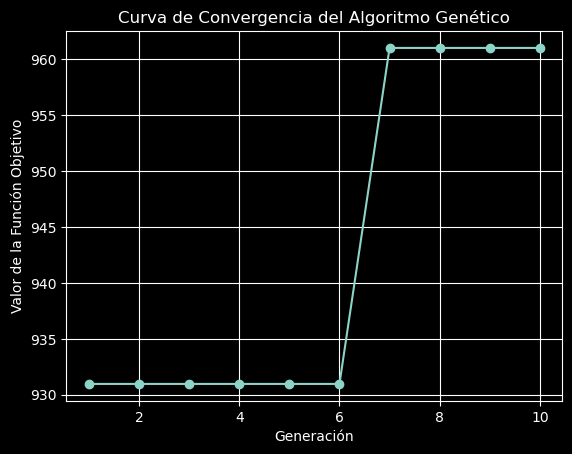

Mejor solución: 31.0 Aptitud: 961.0


In [150]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = 0
X_MAX = 31
OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

### EJERCICIO 2

#### 2.1_Selecccion Ruleta

_________________________________________________________________________________

Generación: 1
Aptitud total: 6.4100219763841695
mi 0111111001
Mejor individuo: -0.3939393939393945 Aptitud: 6.402530439946129
_________________________________________________________________________________
Generación: 2
Aptitud total: 12.98572845478484
mi 0111111001
Mejor individuo: -0.3939393939393945 Aptitud: 6.402530439946129
_________________________________________________________________________________
Generación: 3
Aptitud total: 14.224168013483085
mi 0111111001
Mejor individuo: -0.3939393939393945 Aptitud: 6.402530439946129
_________________________________________________________________________________
Generación: 4
Aptitud total: 14.224168013483085
mi 0111111001
Mejor individuo: -0.3939393939393945 Aptitud: 6.402530439946129
_________________________________________________________________________________
Generación: 5
Aptitud total: 25.610121759784516
mi 0111111001
Mejor individuo: -0.3939

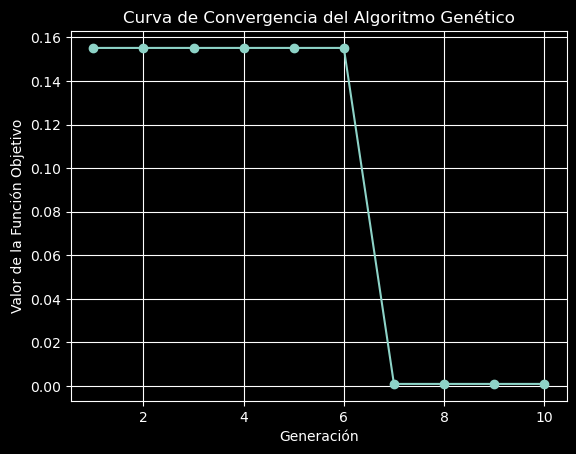

Mejor solución: -0.030303030303031164 Aptitud: 521.3020584011347


In [154]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo


#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

#### 2.2_Seleccion Torneo

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.008435907865957316
mi 0011101111
Mejor individuo: -16.515151515151516 Aptitud: 0.003666344608537064
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.012243800971112063
mi 0111101111
Mejor individuo: -1.0 Aptitud: 0.9990009990009991
_________________________________________________________________________________
Generación: 3
Aptitud total: 1.0096903266746635
mi 0111100101
Mejor individuo: -1.6060606060606055 Aptitud: 0.38753220983392367
_________________________________________________________________________________
Generación: 4
Aptitud total: 0.39824072853201775
mi 0110110110
Mejor individuo: -4.454545454545453 Aptitud: 0.05039312887605417
_________________________________________________________________________________
Generación: 5
Aptitud total: 0.07088156137554415
mi 0110110111
Mejor individuo: -4.39393

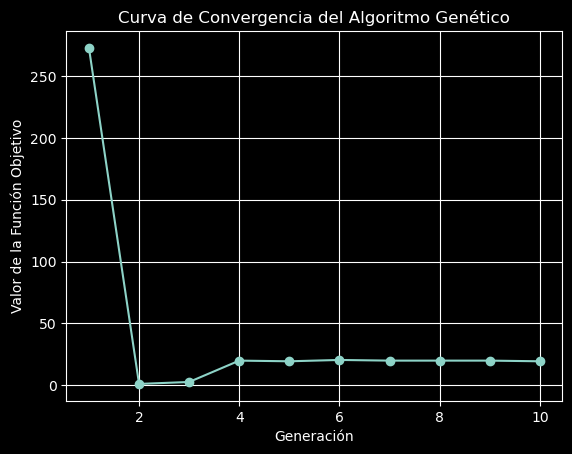

Mejor solución: -4.3939393939393945 Aptitud: 0.05179279893659727


In [157]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = False # True o False
SELECCION = 'torneo' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

#### 2.3_Seleccion Ranking

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.030914280405711887
mi 0110001111
Mejor individuo: -6.818181818181817 Aptitud: 0.021510648393163467
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.0615109622072307
mi 0110001111
Mejor individuo: -6.818181818181817 Aptitud: 0.021510648393163467
_________________________________________________________________________________
Generación: 3
Aptitud total: 0.08328127081066733
mi 0110001111
Mejor individuo: -6.818181818181817 Aptitud: 0.021510648393163467
_________________________________________________________________________________
Generación: 4
Aptitud total: 0.08604259357265387
mi 0110011111
Mejor individuo: -5.848484848484848 Aptitud: 0.029234829479199375
_________________________________________________________________________________
Generación: 5
Aptitud total: 0.09376677465868978
mi 0110101111
Mejor indi

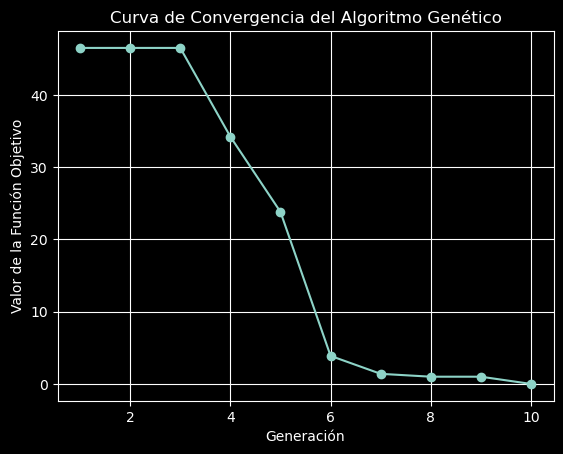

Mejor solución: -0.030303030303031164 Aptitud: 521.3020584011347


In [166]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ranking' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))